---
# Expectation-Maximisation


In this notebook, we illustrate the \textit{Expectation-Maximisation} algorithm through a simple factor analysis example.

In [16]:
#Some libraries that we will be using.
from __future__ import print_function, division
import numpy as np
from scipy.io import loadmat
from scipy.stats import norm
from IPython import display
import math

#Configure the matplotlib backend as plotting inline
%matplotlib inline
import matplotlib.pyplot as plt

#Enables latex
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':'20'})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

---

We assume a simple latent variable model of the form:
$$
y = x + \epsilon
$$

where $x \sim \mathcal{N}(0,1)$ and $ \epsilon \sim \mathcal{N}(0, \sigma_{y}^{2})$. 

The goal of EM is to find the Maximum Likelihood (ML) parameters. 

More concretely, for this case, we seek to maximise $\newcommand\given[1][]{\:#1\vert\:} \log p(y\given{\theta})$ (the log-likelihood of the parameter $\theta = \{\sigma_{y}^{2}\}$). We introduce a distribution over the latent variables $q(x)$ which, through an application of Jensen's inequality, allows us to obtain a lower bound on the log-likelihood:

$$
\mathcal{L} = \log\int q(x)\frac{p(y\given{\theta})}{q(x)}\mathrm{d}x  \geq  \int q(x)\log\frac{p(y\given{\theta})}{q(x)}\mathrm{d}x = \mathcal{F}(q,\theta)
$$

where $\mathcal{F}(q,\theta)$ is the lower bound of the log-likelihood.

The amount by which the log-likelihood exceeds the lower bound can be shown to be the \textit{Kullback-Leibler} (KL) divergence between $q(x)$ and the posterior distribution of the latent variables $p(x\given{y,\theta})$:

$$
\mathcal{F}(q,\theta) = \log p(y\given{\theta}) - \mathcal{KL}(q(x)||p(x\given{y,\theta}))
$$

This shows that for fixed $\theta$, the optimum value for $q$ is equal to $p(x\given{y,\theta})$ which causes the KL to vanish thus leaving the free-energy to be equal to the log-likelihood. The EM algorithm then follows:

\begin{itemize}
\item \textbf{E-Step} - We maximise $\mathcal{F}(q,\theta)$ \textbf{with respect to} $\mathbf{q}$ by setting $q(x) = p(x\given{y,\theta})$. In this case, as we assume a model of the form $p(x) = Norm(\mu_{0},\sigma_{0}^{2})$ and $p(y\given{x, \sigma_{y}^{2}}) = Norm(x,\sigma_{y}^{2})$ (the likelihood is then $p(y\given{\sigma_{y}^{2}}) = Norm(y;\mu_{0}, \sigma_{0}^{2} + \sigma_{y}^{2}$). The posterior, $p(x\given{y,\sigma_{y}^{2}})$ (and therefore $q(x)$) becomes:

$$
q(x) = p(x\given{y,\sigma_{y}^{2}}) = Norm\left(x; \mu_{0} + \frac{\sigma_{0}^{2}}{\sigma_{0}^{2} + \sigma_{y}^{2}}(y - \mu_{0}), \frac{\sigma_{y}^{2}\sigma_{0}^{2}}{\sigma_{y}^{2}+\sigma_{0}^{2}}\right)
$$

\item \textbf{M-Step} - This then involves maximising $\mathcal{F}(q,\theta)$ \textbf{with respect to} $\boldsymbol{\theta}$. For this simple single variable case, this has a closed form solution:

$$
\sigma_{y}^{2} = y^{2} - 2y\langle x\rangle_{q} + \langle x^{2}\rangle_{q}
$$
\end{itemize}

We then alternate between these two steps until we reach the ML parameters.

---

First we need to declare the functions that are to be used.

In [31]:
def EStep(y, like_var, prior_mean, prior_var):
    """Updates the q(x) distribution for the latent variables"""
    q_mean = prior_mean + (prior_var/(prior_var+like_var))*(y - prior_mean)
    q_sigma = math.sqrt((prior_var*like_var)/(prior_var + like_var))
    return q_mean, q_sigma 


def MStep(y, q_mean, q_sigma):
    """Updates the noise standard deviation using q(x) parameters"""
    return math.sqrt(y**2 - 2*y*q_mean + q_sigma**2 + q_mean**2)


def calcLowerBound(var_y, q_mean, q_var, prior_mean, prior_var, y):
    """Calculates the lower bound of the log-likelihood of the parameters"""
    post_mean = prior_mean + (prior_var/(prior_var + var_y))*(y - prior_mean)
    post_var = (prior_var*var_y)/(var_y + prior_var)
    KL = -0.5*(np.log(q_var/post_var) + 1 - (q_var + (q_mean - post_mean)**2)/post_var)
    LL = -0.5*np.log(2*math.pi*(prior_var+var_y)) - ((y-prior_mean)**2)/(2*(prior_var+var_y))
    LB = LL - KL
    return LB


def drawTrace(ax, trace):
    
    #Draw E-step and M-step updates trace
    ax.plot(trace[:,0],trace[:,1],'k-')   

    
def plotLowerBoundContour(ax, xv, yv, Z, y, var_y, prior_mean, prior_var):
    """Plots the Free-Energy for each point on the \mu_{q} vs var_y grid"""
    
    # LB contour subplot
    num_levels = 30
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    min_level = min(np.min(Z),np.min([Z[0,0],Z[0,-1],Z[-1,0],Z[-1,-1]]))
    max_level = np.max(Z)
    CS1 = ax.contourf(xv, yv, Z, levels=np.linspace(min_level,max_level,num_levels))
    cbar = plt.colorbar(CS1, ax=ax)
    ax.plot(var_y, prior_mean + (prior_var/(prior_var+var_y))*(y - prior_mean))   #Optimal setting of mean of q(x)

    
def plotLikelihood(ax, var_y, y, prior_mean, prior_var, x_axis, ax_ymin, ax_ymax):
    """Plots log-likelihood against var_y (noise variance)"""
    
    # Likelihood + vertical line for current params
    ax.axvline(x=var_y,ymax=(norm.logpdf(y,loc=prior_mean,\
                                    scale=np.sqrt(var_y+prior_var))-ax_ymin)/(ax_ymax-ax_ymin),color='k')
    ax.plot(x_axis,norm.logpdf(y,loc=prior_mean,scale=np.sqrt(x_axis+prior_var)),'k',label='Log-likelihood')
    

def plotLB(ax, x_axis, q_mean, q_var, prior_mean, prior_var, y, ax_ymin, ax_ymax,label=None,color=None,ls=None):
    """Plots the free-energy against var_y"""
    
    # Plot lower bound for q_mean, q_var and y given
    lb = calcLowerBound(x_axis, q_mean, q_var, prior_mean, prior_var, y)
    opt_var_y_ind = np.argmax(lb)
    opt_var_y = x_axis[opt_var_y_ind]
    opt_LB = lb[opt_var_y_ind]
    ax.axvline(x=opt_var_y,ymax=(opt_LB-ax_ymin)/(ax_ymax-ax_ymin),color=color,ls=ls)
    ax.plot(x_axis,lb,color=color,label=label,ls=ls)

The following code then performs the EM algorithm and makes two plots:

\begin{itemize}
\item A contour plot of the lower bound (free-energy) as a variable of $\mu_{q}$ and $\sigma_{y}^{2}$. The variance of $q$ is set to the optimum value at each point. The change in parameters during the E-Step and M-Step is then shown as vertical and horizontal lines respectively. The blue line corresponds to the optimal setting of $\mu_{q}$
\item A plot of the log-likelihood/lower bound vs. $\sigma_{y}^{2}$ has three lines that indicate the log-likelihood for each $\sigma_{y}^{2}$ (black line), the current lower bound for the current $q$ distribution and the calculated $\sigma_{y}^{2}$ from the M-Step (red line) and the previous lower bound from the previous $q$ distribution (blue dashed line). The vertivcal lines show the maxima of the log-likelihood and the lower bound for each plot.  
\end{itemize}

Final sigma_y estimate:  0.48989782975345086
True sigma_y:  0.1


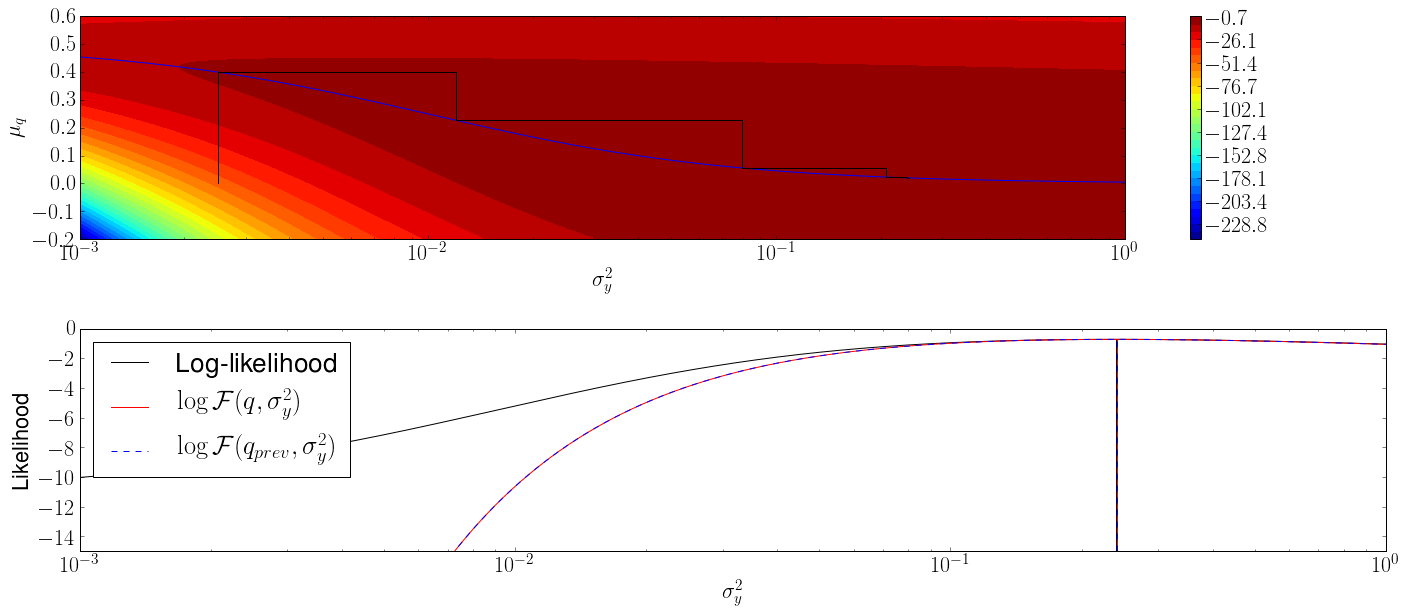

In [35]:

MAX_ITERATIONS = 10000
thresh = 1e-10   #Threshold to test for convergence

true_sigma_y = 0.1 
prior_mean = 0.
prior_var = .01

true_x = 3     #True value of the latent variable to estimate
print("true_x: ",true_x)

y = 0.5 #true_x + true_sigma_y*np.random.randn() 
print("y: ",y)


#Set up figure
fig = plt.figure()
fig.set_size_inches(20,9)

# Range of x-axis (var of y) and y-axis (q(x) mean) values to calc LB for
ax1_xmin = 0.001 
ax1_xmax = 1.0  
ax1_ymin = -0.2
ax1_ymax = 0.6

x_axis = np.logspace(np.log10(ax1_xmin),np.log10(ax1_xmax),1000) 
y_axis = np.linspace(ax1_ymin,ax1_ymax,1000)

ax1 = fig.add_subplot(211,xlim=(ax1_xmin,ax1_xmax),ylim=(ax1_ymin,ax1_ymax))
ax1.set_xlabel(r'$\sigma_{y}^{2}$')
ax1.set_ylabel(r'$\mu_{q}$')
ax1.set_xscale('log')

# Limits of second plot
ax2_xmin = ax1_xmin 
ax2_xmax = ax1_xmax 
ax2_ymin = -15. 
ax2_ymax = 0. 
 
    
ax2 = fig.add_subplot(212,xlim=(ax2_xmin,ax2_xmax),ylim=(ax2_ymin,ax2_ymax))
ax2.set_xlabel(r'$\sigma_{y}^{2}$')
ax2.set_ylabel('Likelihood')
ax2.set_xscale('log')

fig.tight_layout()

   
sigma_y = 0.05#np.random.uniform()
sigma_y_prev = sigma_y
q_mean_prev = 0
q_sigma_prev = 0.5

update_history = np.array([[sigma_y**2, 0]])    #History of update steps
log_like = np.array([norm.pdf(y,loc=prior_mean,scale=math.sqrt(sigma_y**2+prior_var))])

#Evaluate LB at all points on grid
xv, yv = np.meshgrid(x_axis,y_axis)
Z = calcLowerBound(xv, yv, (xv*prior_var)/(prior_var+xv), prior_mean, prior_var, y)
plotLowerBoundContour(ax1, xv, yv, Z, y, x_axis, prior_mean, prior_var)
    
runTillEnd = False
num_iter = 0
while ((sigma_y - sigma_y_prev)**2 > thresh or num_iter == 0):
    
    if not runTillEnd:
        if input("E-Step. (Type 'rte' to run simulation to end): ") == 'rte':
            runTillEnd = True
        
    #Remove previous plots
    if num_iter > 0:
        del ax1.lines[-1]
        del ax2.lines[-6:]
        
    #E-Step
    q_mean, q_sigma = EStep(y, sigma_y**2, prior_mean, prior_var)
    
    update_history = np.append(update_history,[[sigma_y**2, q_mean]],axis=0)
    
    
    display.clear_output(wait=True)
    drawTrace(ax1,update_history)
    plotLikelihood(ax2, sigma_y**2, y, prior_mean, prior_var, x_axis, ax2_ymin, ax2_ymax)
    plotLB(ax2, x_axis, q_mean, q_sigma**2, prior_mean, prior_var, y, ax2_ymin, ax2_ymax,\
            label=r'$\log \mathcal{F}(q,\sigma_{y}^{2})$',color='red',ls='-')
    if num_iter > 0:
        plotLB(ax2, x_axis, q_mean_prev, q_sigma_prev**2, prior_mean, prior_var, y, ax2_ymin, ax2_ymax,\
                label=r'$\log \mathcal{F}(q_{prev},\sigma_{y}^{2})$',color='blue',ls='--')
    display.display(plt.gcf())
    
    if num_iter == 1:
        ax2.legend(loc=2)
    
    print("###E-STEP###")
    print("Squared change: " , (sigma_y-sigma_y_prev)**2)
    print("var_y: ", sigma_y**2)
    print("Likelihood: ", log_like[-1])
    print("Lower bound: ", calcLowerBound(sigma_y**2, q_mean, q_sigma**2, prior_mean, prior_var, y))
    print("q(x) parameters:")
    print("   q_mean = ", q_mean)
    print("   q_var = ", q_sigma**2)
        
        
    if not runTillEnd:
        if input("M-Step. (Type 'rte' to run simulation to end): ") == 'rte':
            runTillEnd = True
        
      
    #Store previous sigma_y
    sigma_y_prev = sigma_y
        
    #Remove previous E-Step plots
    del ax1.lines[-1]
    del ax2.lines[-6:]
        
    #M-Step
    sigma_y = MStep(y, q_mean, q_sigma)
        
    log_like = np.append(log_like,norm.pdf(y,loc=prior_mean,scale=math.sqrt(sigma_y**2+prior_var)))
    update_history = np.append(update_history,[[sigma_y**2, q_mean]],axis=0)
    
    display.clear_output(wait=True)
    drawTrace(ax1,update_history)
    plotLikelihood(ax2, sigma_y**2, y, prior_mean, prior_var, x_axis, ax2_ymin, ax2_ymax)
    plotLB(ax2, x_axis, q_mean, q_sigma**2, prior_mean, prior_var, y, ax2_ymin, ax2_ymax,\
            label=r'$\log \mathcal{F}(q,\sigma_{y}^{2})$',color='red',ls='-')
    if num_iter > 0:
        plotLB(ax2, x_axis, q_mean_prev, q_sigma_prev**2, prior_mean, prior_var, y, ax2_ymin, ax2_ymax,\
                label=r'$\log \mathcal{F}(q_{prev},\sigma_{y}^{2})$',color='blue',ls='--')
    display.display(plt.gcf())
    
    
    
    print("####################")
    print("###M-STEP###")
    print("Squared change: " , (sigma_y-sigma_y_prev)**2)
    print("var_y: ", sigma_y**2)
    print("likelihood: ", log_like[-1])
    print("Lower bound: ", calcLowerBound(sigma_y**2, q_mean, q_sigma**2, prior_mean, prior_var, y))
    print("q(x) parameters:")
    print("   q_mean = ",q_mean)
    print("   q_var = ",q_sigma**2)
        
       
    q_mean_prev = q_mean
    q_sigma_prev = q_sigma
    num_iter += 1

display.clear_output(wait=True)